# 제 5회 빅콘테스 챌린지리그

- 문제 : 보험, 통신, 신용평가사 (개인정보 비식별)결합데이터를 활용한 대출상환 예측 알고리즘 개발
- 제공데이터 및 내용 : 개인정보 비식별화 한 SK텔레콤 데이터등 , 개인정보 비식별화 한 SCI평가정보 및 한화생명 데이터 등
- 참가대상 : 대학생 이상 일반인포함 
- http://contest.kbig.kr/sub/sub_question.php

In [960]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import cufflinks as cf
cf.go_offline()

%matplotlib inline

# Data

![data](https://files.slack.com/files-tmb/T5AP56SQ3-F6KH2CRUG-10cc1c9afd/_______________________________2017-08-09______________9.10.59_1024.png)

![data](https://files.slack.com/files-tmb/T5AP56SQ3-F6KH2DK6U-4852329394/_______________________________2017-08-09______________9.11.38_1024.png)

![data컬럼설명](https://files.slack.com/files-tmb/T5AP56SQ3-F6L6VB5LJ-5e28475264/_______________________________2017-08-09______________9.11.58_1024.png)

In [961]:
train = pd.read_csv('Data_set.csv', encoding='cp949')

In [962]:
train.tail()

CUST_ID  TARGET  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  \
100228   102248       0             1             0               2   
100229   102249       0             2             0               0   
100230   102250       0             1             0               0   
100231   102251       0             0             0               1   
100232   102252       0             1             0               0   

        ECT_LNIF_CNT  TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  \
100228             2         75001         15001         57001             0   
100229             0         54001          9001         54001             0   
100230             0         27001         27001         27001             0   
100231             1         57001             0             0             0   
100232             0         18001         18001         18001             0   

          ...      CBPT_MBSP_YN  MOBL_FATY_PRC  TEL_CNTT_QTR  NUM_DAY_SUSP  \
100228    ...                 N              0         20111             0   
100229    ...                 Y         900000         20134             0   
100230    ...                 N              0         20141             0   
100231    ...                 N         900000         20103             0   
100232    ...                 N         400000         20151             0   

        CRMM_OVDU_AMT  TLFE_UNPD_CNT LT1Y_MXOD_AMT  PAYM_METD  LINE_STUS  \
100228          20000              0             0          R          U   
100229              0              0             0          K          U   
100230              0              0             0          O          U   
100231              0              0             0          O          U   
100232              0              0         60000          K          U   

        MOBL_PRIN  
100228          0  
100229     180000  
100230          0  
100231     540000  
100232     180000  

[5 rows x 69 columns]

In [963]:
train.shape

(100233, 69)

In [964]:
grouped = train['TARGET'].value_counts()
grouped

0    95946
1     4287
Name: TARGET, dtype: int64

## 1 . 변수 탐색
. train 데이터로 주어진 고객 수 :100233명

1) y값 : 대출연체 여부
      - 0 (미발생): 95946명
      - 1 (발생) : 4287명

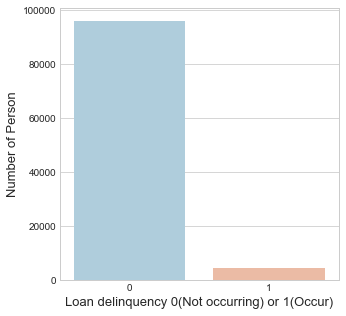

In [965]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 5))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Person', fontsize=13)
plt.xlabel('Loan delinquency 0(Not occurring) or 1(Occur)', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

2) x 값 : 68 개 컬럼                                                                                                                  

In [966]:
train_1 = train.copy()

In [967]:
del train_1['TARGET']

In [968]:
train_1.tail()

CUST_ID  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  ECT_LNIF_CNT  \
100228   102248             1             0               2             2   
100229   102249             2             0               0             0   
100230   102250             1             0               0             0   
100231   102251             0             0               1             1   
100232   102252             1             0               0             0   

        TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  \
100228         75001         15001         57001             0   
100229         54001          9001         54001             0   
100230         27001         27001         27001             0   
100231         57001             0             0             0   
100232         18001         18001         18001             0   

        CRDT_OCCR_MDIF    ...      CBPT_MBSP_YN  MOBL_FATY_PRC  TEL_CNTT_QTR  \
100228              37    ...                 N              0         20111   
100229              85    ...                 Y         900000         20134   
100230               1    ...                 N              0         20141   
100231               1    ...                 N         900000         20103   
100232              49    ...                 N         400000         20151   

        NUM_DAY_SUSP  CRMM_OVDU_AMT TLFE_UNPD_CNT  LT1Y_MXOD_AMT  PAYM_METD  \
100228             0          20000             0              0          R   
100229             0              0             0              0          K   
100230             0              0             0              0          O   
100231             0              0             0              0          O   
100232             0              0             0          60000          K   

        LINE_STUS  MOBL_PRIN  
100228          U          0  
100229          U     180000  
100230          U          0  
100231          U     540000  
100232          U     180000  

[5 rows x 68 columns]

In [969]:
train_X = train_1.copy()
del train_1

In [970]:
list_x = list(train_X.columns)

## (1) null 값 처리
    -OCCP_NAME_G
    -LAST_CHLD_AGE       
    -MATE_OCCP_NAME_G
    -TEL_MBSP_GRAD
    -PAYM_METD

In [971]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100233 entries, 0 to 100232
Data columns (total 68 columns):
CUST_ID              100233 non-null int64
BNK_LNIF_CNT         100233 non-null int64
CPT_LNIF_CNT         100233 non-null int64
SPART_LNIF_CNT       100233 non-null int64
ECT_LNIF_CNT         100233 non-null int64
TOT_LNIF_AMT         100233 non-null int64
TOT_CLIF_AMT         100233 non-null int64
BNK_LNIF_AMT         100233 non-null int64
CPT_LNIF_AMT         100233 non-null int64
CRDT_OCCR_MDIF       100233 non-null int64
SPTCT_OCCR_MDIF      100233 non-null int64
CRDT_CARD_CNT        100233 non-null int64
CTCD_OCCR_MDIF       100233 non-null int64
CB_GUIF_CNT          100233 non-null int64
CB_GUIF_AMT          100233 non-null int64
OCCP_NAME_G          99769 non-null object
CUST_JOB_INCM        100233 non-null int64
HSHD_INFR_INCM       100233 non-null int64
ACTL_FMLY_NUM        100233 non-null int64
CUST_FMLY_NUM        100233 non-null int64
LAST_CHLD_AGE        99206 no

In [972]:
# 직업 
len(train_X[lambda x: x.OCCP_NAME_G.isnull()])

464

In [973]:
# 배우자 직업
len(train_X[lambda x: x.MATE_OCCP_NAME_G.isnull()]) 

45709

In [974]:
# 막내 자녀 나이 (0 = NULL)
len(train_X[lambda x: x.LAST_CHLD_AGE.isnull()])

1027

In [975]:
# SKT 멤버쉽 등급
len(train_X[lambda x: x.TEL_MBSP_GRAD.isnull()]) 

46015

In [976]:
# 납부 방법 
len(train_X[lambda x: x.PAYM_METD.isnull()]) 

2833

#### 1) 'LAST_CHLD_AGE' 막내 자녀 나이는 nan 값과  0값이 같은 데이터 이므로 0으로 nan 값을 채워 준다

In [1252]:
train_X['LAST_CHLD_AGE'].fillna(0, inplace=True)
train['LAST_CHLD_AGE'].fillna(0, inplace=True)

In [978]:
len(train_X[lambda x: x.LAST_CHLD_AGE.isnull()])

0

#### 2) 'OCCP_NAME_G' 직업은 nan 값과 * 비식별 데이터가 문제가 됨. labelencoding을 해야 하므로  다른 값으로 채워준다.
- labelencoding 시  nan 값들이 0을 가질 수 있도록 string '0'으로 채운다.


In [979]:
len(train_X[lambda x: x.OCCP_NAME_G.isnull()])

464

In [1253]:
train_X['OCCP_NAME_G'].fillna('0', inplace=True)
train['OCCP_NAME_G'].fillna('0', inplace=True)

In [981]:
len(train_X[lambda x: x.OCCP_NAME_G.isnull()])

0

#### 3) 'MATE_OCCP_NAME_G' 배우자 직업은 nan 값과 * 비식별 데이터가 문제가 됨. labelencoding을 해야 하므로  다른 값으로 채워준다.
- labelencoding 시  nan 값들이 0을 가질 수 있도록 string '0'으로 채운다.
- 그러나, OCCP_NAME_G와 달리 null 값이 너무 많음. 사용할지 말지 고민...
- 배우자가 없거나, 배우자가 직업이 없을 경우 nan 인듯

In [982]:
len(train_X[lambda x: x.MATE_OCCP_NAME_G.isnull()])

45709

In [1254]:
train_X['MATE_OCCP_NAME_G'].fillna('0', inplace=True)
train['MATE_OCCP_NAME_G'].fillna('0', inplace=True)

In [984]:
len(train_X[lambda x: x.MATE_OCCP_NAME_G.isnull()])

0

#### 4) 'TEL_MBSP_GRAD'  멤버쉽 등급 nan 은 멤버쉽 등급 정보가 없음
- 2g폰 사용자라도 멤버쉽 등급은 있는데... 왜 nan 값일까...
- MATE_OCCP_NAME_G와 마찬가지로 null 값이 너무 많음. 사용할지 말지 고민...

In [985]:
len(train_X[lambda x: x.TEL_MBSP_GRAD.isnull()]) 

46015

In [1255]:
train_X['TEL_MBSP_GRAD'].fillna('0', inplace=True)
train['TEL_MBSP_GRAD'].fillna('0', inplace=True)

In [987]:
len(train_X[lambda x: x.TEL_MBSP_GRAD.isnull()]) 

0

#### 5) 'PAYM_METD' 납부 방법 
- 납부방법 nan 값은 0으로 처리

In [988]:
len(train_X[lambda x: x.PAYM_METD.isnull()]) 

2833

In [1256]:
train_X['PAYM_METD'].fillna('0', inplace=True)
train['PAYM_METD'].fillna('0', inplace=True)

In [990]:
len(train_X[lambda x: x.PAYM_METD.isnull()]) 

0

## (2) 질적 변수 , 양적 변수 
- (Scatter Plot) 그리기

In [991]:
def variable(var_x):
    (train.iplot(kind='scatter', mode='markers', y=var_x,subplots=True))

### 1) list_x [0:10] 

1) 양적변수

  - 'CUST_ID'(고객_ID), 
  - 'BNK_LNIF_CNT'(대출 정보 현재 총 건수[은행]) ,
  - 'CPT_LNIF_CNT'(대출 정보 현재 총 건수[카드사/할부사/캐피탈])
  - 'SPART_LNIF_CNT'(대출 정보 현재 총 건수 [2차산업분류]),
  - 'ECT_LNIF_CNT'(대출정보 현재 총 건수[기타]),
  - 'TOT_LNIF_AMT'(대출정보 현재 총 금액),
  - 'TOT_CLIF_AMT'(대출정보 현재 총 금액[신용대출]),
  - 'BNK_LNIF_AMT'(대출정보 현재 총 금액[은행]),
  - 'CPT_LNIF_AMT'(대출정보 현재 총 금액[카드사/할부사/캐피탈]),
  - 'CRDT_OCCR_MDIF'(대출정보 최근 개설일로부터 현재까지 유지기간[신용대출])

In [992]:
def scatter_plot(start,end):
    with plt.style.context(('seaborn-white')):
        sns_plot = sns.pairplot(train_X[list_x[start:end]] ,size=1.5
                               )
    plt.show()

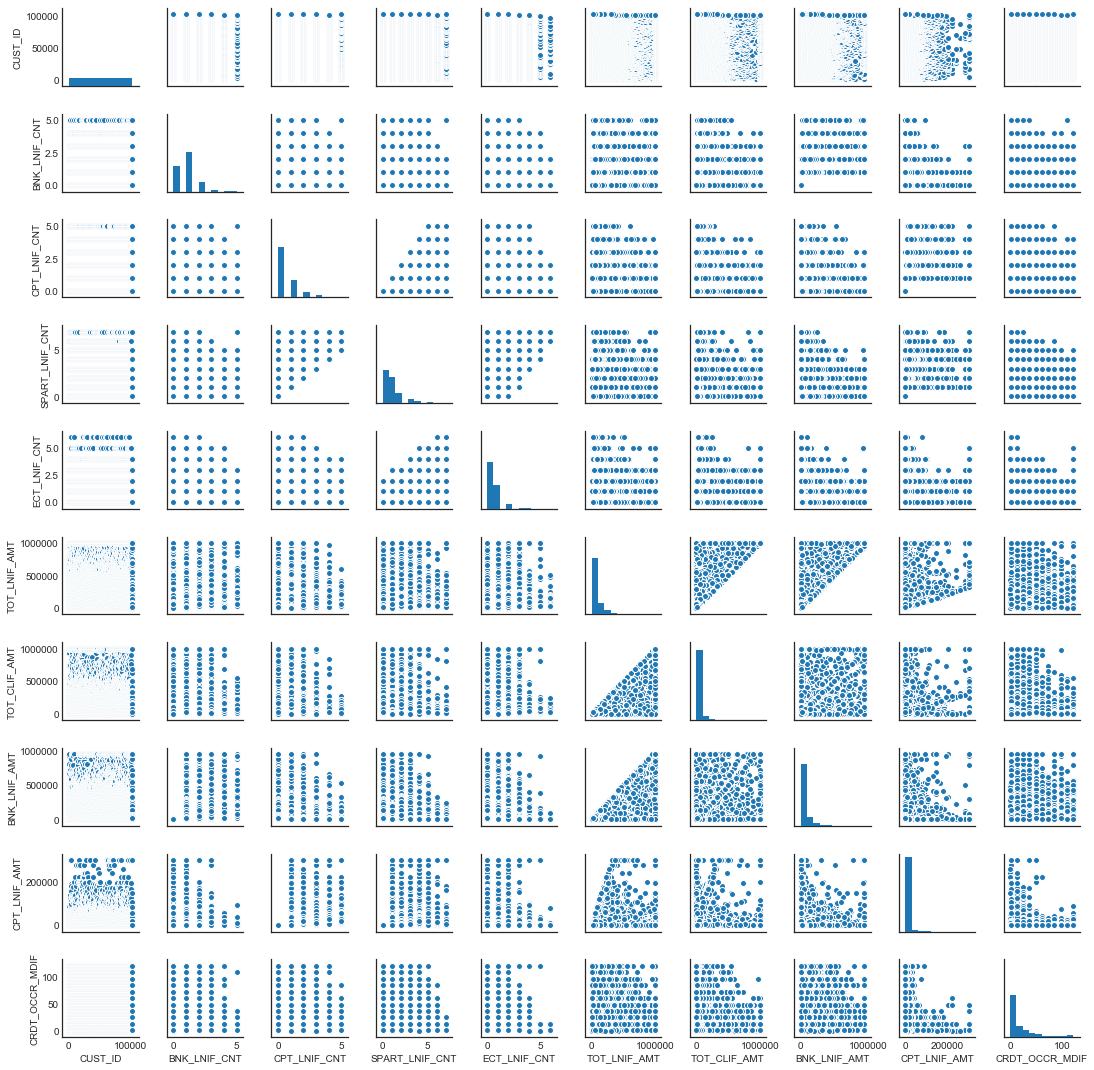

In [766]:
scatter_plot(0,10)

### 2) list_x [10:20] 

1) 양적변수
    
    -'SPTCT_OCCR_MDIF'(대출정보 최근 개설일로부터 현재까지 유지기간[2산업분류-신용대출]),
    -'CRDT_CARD_CNT'(개설정보 현재 신용개설 총 건수[신용카드]),
    -'CTCD_OCCR_MDIF'(개설정보 최초 개설일로부터 현재까지 유지기간[신용카드]),
    -'CB_GUIF_CNT'(보증정보 현재 보증 총 건수),
    -'CB_GUIF_AMT'(보증정보 현재 보증 총 금액),
    -'CUST_JOB_INCM'(추정소득),
    -'HSHD_INFR_INCM'(가구추정소득),
    -'ACTL_FMLY_NUM'(실가족원수),
    -'CUST_FMLY_NUM'(보험가입가족원수)

2) 질적변수

    -'OCCP_NAME_G'(직업)

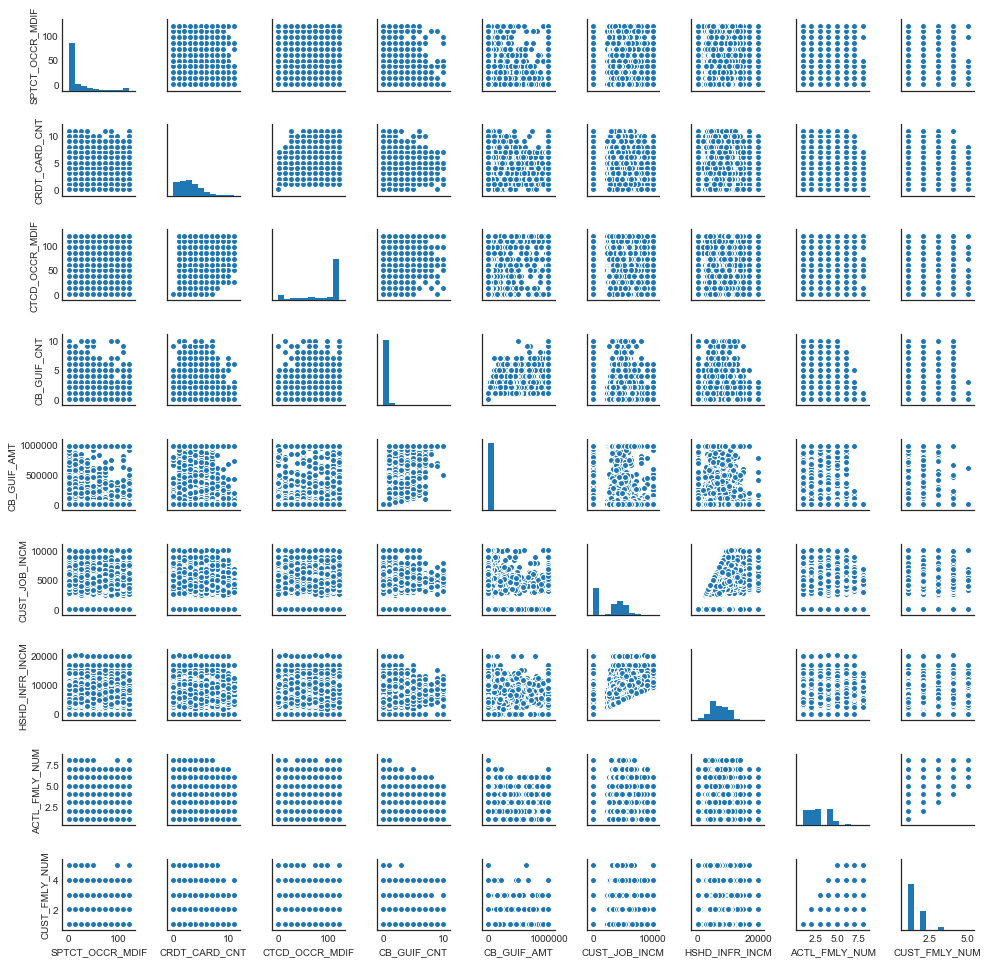

In [17]:
scatter_plot(10,20)

In [150]:
def bar_chart(x_val, title):
    x_bar = train_X[x_val].value_counts()
    x_bar.iplot(kind='bar',title=title)  

In [151]:
#NULL, *(비식별처리)
bar_chart('OCCP_NAME_G','산출일 기준 대분류 직업 정보')

In [1257]:
dia_yn = (train
  .groupby(['OCCP_NAME_G', 'TARGET'])
  .size()
)

In [1258]:
dia_yn.unstack('TARGET')

TARGET           0     1
OCCP_NAME_G             
*             1145    44
0              437    27
1차산업 종사자      1135    43
2차산업 종사자      9161   440
3차산업 종사자      7912   363
고소득 전문직       1173    50
공무원           4910   181
기업/단체 임원      1004    37
기타            1606    66
단순 노무직         792    29
단순 사무직        3913   194
사무직          15886   695
예체능계 종사자       895    41
운전직           2034    92
자영업           9060   425
전문직           4825   218
주부           26433  1132
학생            3625   210

In [1259]:
df = train.groupby('OCCP_NAME_G')['OCCP_NAME_G'].size()

In [1260]:
a = dia_yn.unstack('TARGET')

In [1263]:
df = pd.DataFrame(df)


In [1264]:
merge_df = pd.merge(a,df , left_index=True ,right_index=True)

In [1265]:
merge_df.tail()

0     1  OCCP_NAME_G
OCCP_NAME_G                          
운전직           2034    92         2126
자영업           9060   425         9485
전문직           4825   218         5043
주부           26433  1132        27565
학생            3625   210         3835

In [1266]:
merge_df.columns

Index([0, 1, 'OCCP_NAME_G'], dtype='object')

In [1267]:
merge_df['OCCP_0_probability'] = merge_df[0]/merge_df['OCCP_NAME_G'] * 100

In [1270]:
merge_df['OCCP_1_probability'] = merge_df[1]/merge_df['OCCP_NAME_G'] * 100
merge_df.tail()

0     1  OCCP_NAME_G  OCCP_0_probability  OCCP_1_probability
OCCP_NAME_G                                                                  
운전직           2034    92         2126           95.672625            4.327375
자영업           9060   425         9485           95.519241            4.480759
전문직           4825   218         5043           95.677176            4.322824
주부           26433  1132        27565           95.893343            4.106657
학생            3625   210         3835           94.524120            5.475880

In [1271]:
list_mer = ['OCCP_1_probability']

In [1272]:
merge_df[list_mer].iplot(kind='bar',barmode='stack' ,title = '직업별 연체 비율')

In [1239]:
(dia_yn
 .unstack('TARGET')
 .iplot(kind='bar')
)

In [1158]:
dia_cutcolor = (train
  .groupby(['OCCP_NAME_G', 'MATE_OCCP_NAME_G'])
  .size()
)

In [1162]:
(dia_cutcolor
 .unstack('MATE_OCCP_NAME_G')
 .iplot(kind='bar', barmode='stack')
)

### 3) list_x [20:30] 

1) 양적변수
    
    -'MATE_JOB_INCM' (배우자추정소득)
    -'CRDT_LOAN_CNT'(신용대출건수),
    -'TOT_CRLN_AMT'(한화생명신용대출금액),
    -'TOT_REPY_AMT'(한화생명신용상환금액),
    -'CRLN_OVDU_RATE'(신용대출연체율),
    -'CRLN_30OVDU_RATE'(30일이내신용대출연체율),
    -'LT1Y_CLOD_RATE'(최근1년신용대출연체율)

2) 질적변수

    -'LAST_CHLD_AGE'(막내자녀나이),
    -'MATE_OCCP_NAME_G'(배우자직업),
    -'MIN_CNTT_DATE'(최초대출날짜),

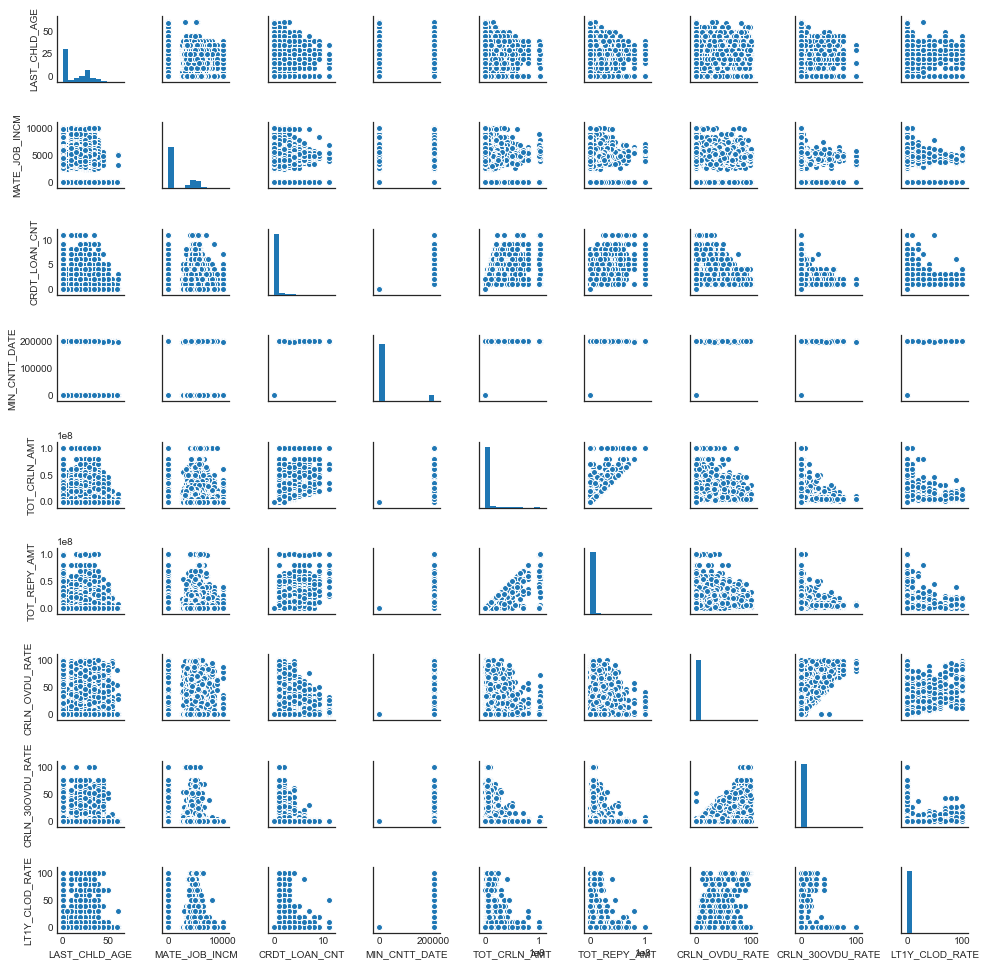

In [31]:
scatter_plot(20,30)

In [152]:
bar_chart('LAST_CHLD_AGE','막내 자녀 나이')

In [153]:
bar_chart('MATE_OCCP_NAME_G' , '배우자직업')

In [157]:
bar_chart('MIN_CNTT_DATE','최초대출날짜(한화생명에서 실행된 최초의 신용대출의 년월)')

#### 'MIN_CNTT_DATE'의 대부분의 데이터가 0 !
    - 대부분 한화생명에서 신용대출한 이력이 없는 사람들
    - 한화에서 신용대출을 한적이 있는지 0,1 로 나누어야 하는가..?

In [173]:
train_X.loc[train_X['MIN_CNTT_DATE']==0].count()  

CUST_ID              90366
BNK_LNIF_CNT         90366
CPT_LNIF_CNT         90366
SPART_LNIF_CNT       90366
ECT_LNIF_CNT         90366
TOT_LNIF_AMT         90366
TOT_CLIF_AMT         90366
BNK_LNIF_AMT         90366
CPT_LNIF_AMT         90366
CRDT_OCCR_MDIF       90366
SPTCT_OCCR_MDIF      90366
CRDT_CARD_CNT        90366
CTCD_OCCR_MDIF       90366
CB_GUIF_CNT          90366
CB_GUIF_AMT          90366
OCCP_NAME_G          90366
CUST_JOB_INCM        90366
HSHD_INFR_INCM       90366
ACTL_FMLY_NUM        90366
CUST_FMLY_NUM        90366
LAST_CHLD_AGE        90366
MATE_OCCP_NAME_G     90366
MATE_JOB_INCM        90366
CRDT_LOAN_CNT        90366
MIN_CNTT_DATE        90366
TOT_CRLN_AMT         90366
TOT_REPY_AMT         90366
CRLN_OVDU_RATE       90366
CRLN_30OVDU_RATE     90366
LT1Y_CLOD_RATE       90366
                     ...  
GDINS_MON_PREM       90366
SVINS_MON_PREM       90366
FMLY_GDINS_MNPREM    90366
FMLY_SVINS_MNPREM    90366
MAX_MON_PREM         90366
TOT_PREM             90366
F

### 4) list_x [30:40] 

1) 양적변수
    
    -'PREM_OVDU_RATE' (보험료연체율),
    -'AVG_STLN_RATE'  (평균약대율),
    -'STLN_REMN_AMT'  (약관대출가능잔액),
    -'LT1Y_STLN_AMT'  (최근1년약대금액),
    -'LT1Y_SLOD_RATE' (최근1년약대연체율),
    -'GDINS_MON_PREM' (非연금저축상품월납입보험료),
    -'SVINS_MON_PREM' (연금저축상품월납입보험료)

2) 질적변수

    -'STRT_CRDT_GRAD' (최초신용등급)   
    -'LTST_CRDT_GRAD' (최근신용등급)
    -'LT1Y_PEOD_RATE' (최근1년보험료연체율)

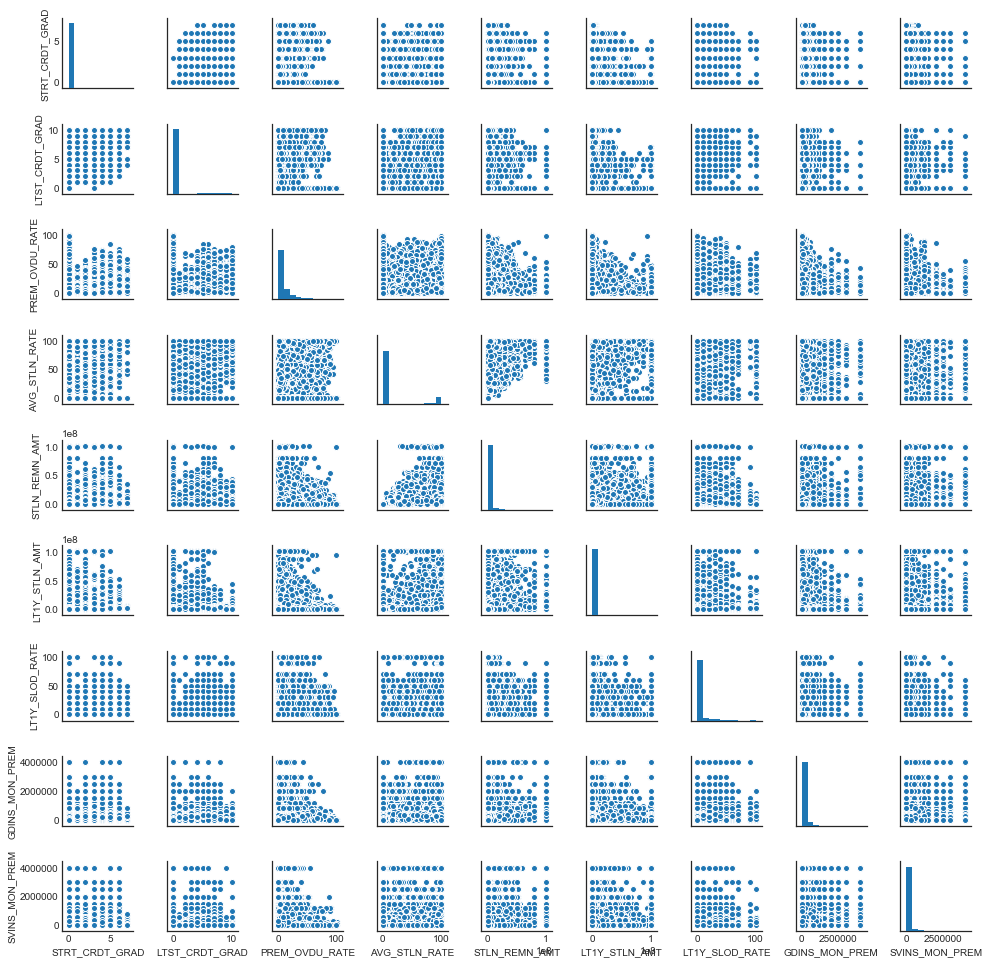

In [32]:
scatter_plot(30,40)

In [174]:
# 0(등급없음)
bar_chart('STRT_CRDT_GRAD','최초신용등급')

In [175]:
# 0(등급없음)
bar_chart('LTST_CRDT_GRAD','최근신용등급')

In [176]:
#(최근1년보험료연체율)
train_X.LT1Y_PEOD_RATE.value_counts() 

0       73274
10미만    12462
20미만     7197
30미만     3021
40미만     1758
50미만      848
90미만      704
60미만      684
90이상      285
Name: LT1Y_PEOD_RATE, dtype: int64

In [177]:
bar_chart('LT1Y_PEOD_RATE', '최근1년보험료연체율' )

### 5) list_x [40:50] 

1) 양적변수
    
    -'FMLY_GDINS_MNPREM',(非가구연금저축상품월납입보험료)
    -'FMLY_SVINS_MNPREM',(가구非연금저축상품월납입보험료)
    -'MAX_MON_PREM',     (최대월납입보험료)
    -'TOT_PREM',         (기납입보험료)
    -'FMLY_TOT_PREM',    (가구기납입보험료)
    -'CNTT_LAMT_CNT',    (실효해지건수)
    -'LT1Y_CTLT_CNT',    (최근1년 실효해지건수)
    -'AUTR_FAIL_MCNT',   (자동이체실패월수)
    -'FYCM_PAID_AMT',    (가구총지급보험금액)
    -'FMLY_CLAM_CNT'     (가구총보험금청구건수)

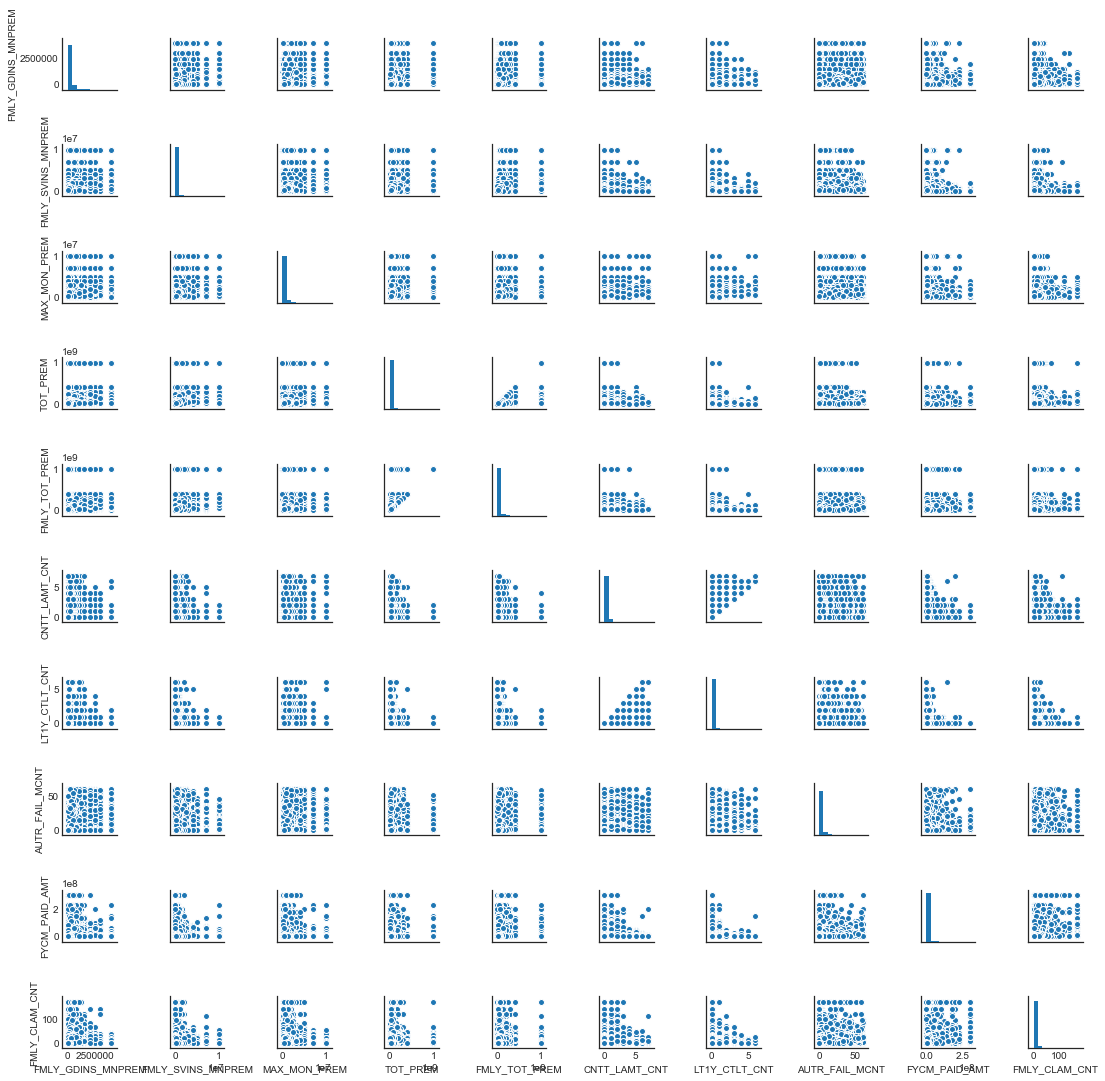

In [178]:
scatter_plot(40,50)

### 6) list_x [50:60] 

1) 양적변수

    -'FMLY_PLPY_CNT', (가구만기완납경험횟수)
    -'AVG_CALL_TIME', (월통화시간_분)
    -'AVG_CALL_FREQ', (월통화빈도)
    -'TEL_MBSP_GRAD', (멤버쉽등급)
    -'ARPU',          (가입자매출_원)
    -'MON_TLFE_AMT',  (납부요금_원)
    -'MOBL_FATY_PRC'  (단말기가격_원)

2) 질적변수


    -'AGE',           (연령)  ** str 처리 되어있음 int 형으로 바꿔야 함
    -'SEX',           (성별)
    -'TEL_MBSP_GRAD', (멤버쉽등급)
    -'CBPT_MBSP_YN',  (결합상품가입여부)

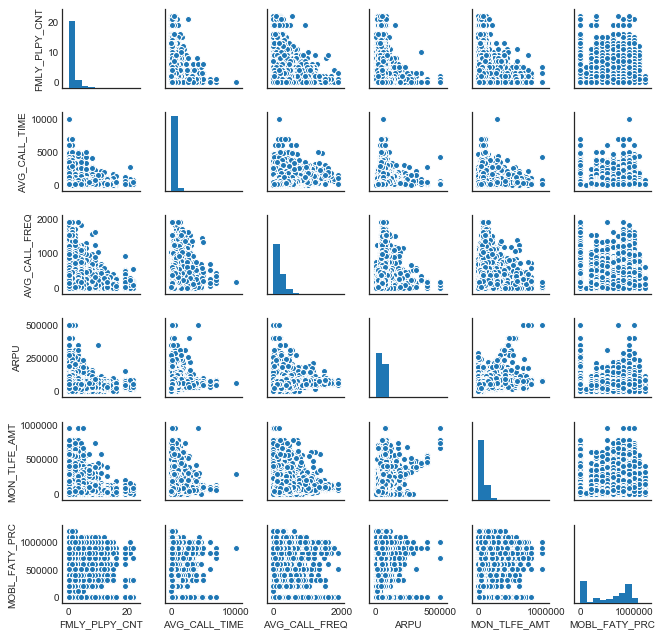

In [38]:
scatter_plot(50,60)

## ** 데이터 고객들의 연령은 20대 이상

In [179]:
len(train_X['AGE'])

100233

In [180]:
bar_chart('AGE' , '연령')  # str -> int 변환 필요 & * (비식별) 처리...?

In [181]:
# 1 : 남자  , 2: 여자
bar_chart('SEX' , '성별')  # str -> int 변환 필요

In [182]:
#VIP / Gold / Silver / 일반
bar_chart('TEL_MBSP_GRAD' , '멤버쉽등급')

In [183]:
bar_chart('CBPT_MBSP_YN','결합상품 가입 여부') # 라벨 인코딩으로 전처리 

### 6) list_x [60:68] 

1) 양적변수

    -'TEL_CNTT_QTR', (가입년월_분기)
    -'NUM_DAY_SUSP', (정지일수)
    -'CRMM_OVDU_AMT',(당월연체금액_원)
    -'TLFE_UNPD_CNT',(납부일미준수횟수)
    -'LT1Y_MXOD_AMT',(년간최대연체금액_원)
    -'MOBL_PRIN'     (남은할부금_원)
  
2) 질적변수

    -'PAYM_METD',    (납부방법)
    -'LINE_STUS',    (회선상태)

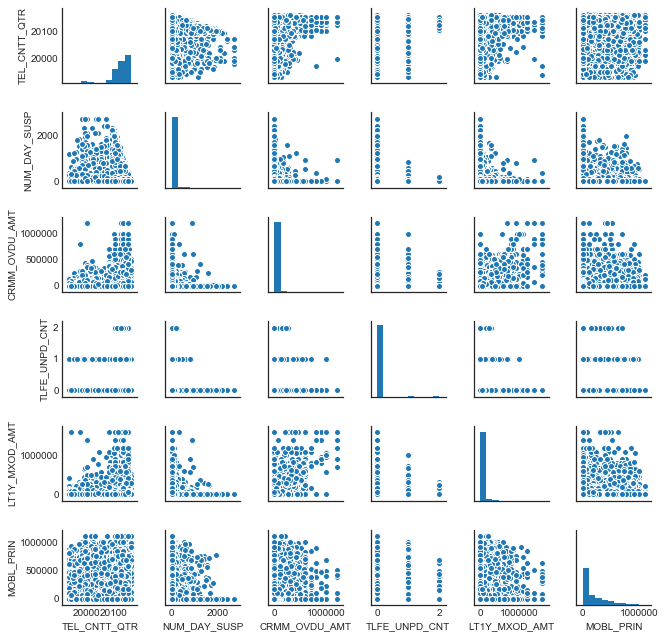

In [52]:
scatter_plot(60,68)

In [51]:
bar_chart('PAYM_METD','납부방법')

In [52]:
#S(정지), U(사용)
bar_chart('LINE_STUS','회선상태')

## 2.질적변수 변환하기

### (1) label encoding  -  LightGBM에서 사용 가능

** 질적변수
   
    -'OCCP_NAME_G'(직업)
    -'MATE_OCCP_NAME_G'(배우자직업),
    -'MIN_CNTT_DATE'(최초대출날짜),
    -'STRT_CRDT_GRAD' (최초신용등급)  
    -'LTST_CRDT_GRAD' (최근신용등급)
    -'LT1Y_PEOD_RATE' (최근1년보험료연체율)
    -'AGE',           (연령)  ** str 처리 되어있음 int 형으로 바꿔야 함
    -'SEX',           (성별)
    -'TEL_MBSP_GRAD', (멤버쉽등급)
    -'CBPT_MBSP_YN',  (결합상품가입여부)
    -'PAYM_METD',    (납부방법)
    -'LINE_STUS',    (회선상태)

* 질적 변수 중 라벨 인코딩이 필요한 변수리스트

    -'OCCP_NAME_G'(직업),'MATE_OCCP_NAME_G'(배우자직업)  ==> 같은 라벨로 인코딩 되어야 함
    -'LT1Y_PEOD_RATE' (최근1년보험료연체율)
    -'SEX',           (성별)
    -'TEL_MBSP_GRAD', (멤버쉽등급)
    -'CBPT_MBSP_YN',  (결합상품가입여부)
    -'PAYM_METD',    (납부방법)
    -'LINE_STUS',    (회선상태)

* 질적 변수 중 str --> int 형으로 바꿔야 하는 변수

    -'AGE',           (연령)  ** str 처리 되어있음 int 형으로 바꿔야 함

### 1) * --> '비식별'로 text 바꾸기 (굳이 안해도 되는 작업)
    - 'OCCP_NAME_G'(직업),'MATE_OCCP_NAME_G'(배우자직업)

In [993]:
train_X['OCCP_NAME_G'] = train_X['OCCP_NAME_G'].apply(lambda x: '비식별' if x == '*' else x)

In [994]:
train_X['MATE_OCCP_NAME_G'] = train_X['MATE_OCCP_NAME_G'].apply(lambda x: '비식별' if x == '*' else x)

In [995]:
train_X.OCCP_NAME_G.tail(10)

100223     주부
100224    전문직
100225    사무직
100226    비식별
100227    자영업
100228    자영업
100229    운전직
100230    자영업
100231    사무직
100232    사무직
Name: OCCP_NAME_G, dtype: object

### 2)str -> int 형으로 값 바꾸기
   - 'AGE',           (연령)  

In [996]:
train_X['AGE'] = train_X['AGE'].apply(lambda x : 0 if x == '*' else int(x))

In [997]:
train_X['AGE'].head()

0    50
1    50
2    60
3    35
4    45
Name: AGE, dtype: int64

In [998]:
Y_target = train['TARGET']

In [999]:
X_train_label = train_X.copy()

라벨 인코딩 해야할 질적 변수 리스트

In [1000]:
cate_list = ['LT1Y_PEOD_RATE','SEX','TEL_MBSP_GRAD','CBPT_MBSP_YN',\
             'PAYM_METD','LINE_STUS','OCCP_NAME_G','MATE_OCCP_NAME_G']

In [1001]:
from sklearn.preprocessing import LabelEncoder

In [1002]:
def lbl_enc(var_x):
    lbl_enc = LabelEncoder()
    lbl_enc.fit(X_train_label[var_x])
    var_x_lbl = var_x+'_LABEL'
    X_train_label[var_x_lbl] = lbl_enc.transform(X_train_label[var_x])

In [1003]:
for i in cate_list:
    print (i)
    lbl_enc(i)

LT1Y_PEOD_RATE
SEX
TEL_MBSP_GRAD
CBPT_MBSP_YN
PAYM_METD
LINE_STUS
OCCP_NAME_G
MATE_OCCP_NAME_G


In [1004]:
X_train_label.columns

Index(['CUST_ID', 'BNK_LNIF_CNT', 'CPT_LNIF_CNT', 'SPART_LNIF_CNT',
       'ECT_LNIF_CNT', 'TOT_LNIF_AMT', 'TOT_CLIF_AMT', 'BNK_LNIF_AMT',
       'CPT_LNIF_AMT', 'CRDT_OCCR_MDIF', 'SPTCT_OCCR_MDIF', 'CRDT_CARD_CNT',
       'CTCD_OCCR_MDIF', 'CB_GUIF_CNT', 'CB_GUIF_AMT', 'OCCP_NAME_G',
       'CUST_JOB_INCM', 'HSHD_INFR_INCM', 'ACTL_FMLY_NUM', 'CUST_FMLY_NUM',
       'LAST_CHLD_AGE', 'MATE_OCCP_NAME_G', 'MATE_JOB_INCM', 'CRDT_LOAN_CNT',
       'MIN_CNTT_DATE', 'TOT_CRLN_AMT', 'TOT_REPY_AMT', 'CRLN_OVDU_RATE',
       'CRLN_30OVDU_RATE', 'LT1Y_CLOD_RATE', 'STRT_CRDT_GRAD',
       'LTST_CRDT_GRAD', 'PREM_OVDU_RATE', 'LT1Y_PEOD_RATE', 'AVG_STLN_RATE',
       'STLN_REMN_AMT', 'LT1Y_STLN_AMT', 'LT1Y_SLOD_RATE', 'GDINS_MON_PREM',
       'SVINS_MON_PREM', 'FMLY_GDINS_MNPREM', 'FMLY_SVINS_MNPREM',
       'MAX_MON_PREM', 'TOT_PREM', 'FMLY_TOT_PREM', 'CNTT_LAMT_CNT',
       'LT1Y_CTLT_CNT', 'AUTR_FAIL_MCNT', 'FYCM_PAID_AMT', 'FMLY_CLAM_CNT',
       'FMLY_PLPY_CNT', 'AGE', 'SEX', 'AVG_CALL_TIME', '

In [1005]:
X_train_label.tail()

CUST_ID  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  ECT_LNIF_CNT  \
100228   102248             1             0               2             2   
100229   102249             2             0               0             0   
100230   102250             1             0               0             0   
100231   102251             0             0               1             1   
100232   102252             1             0               0             0   

        TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  \
100228         75001         15001         57001             0   
100229         54001          9001         54001             0   
100230         27001         27001         27001             0   
100231         57001             0             0             0   
100232         18001         18001         18001             0   

        CRDT_OCCR_MDIF           ...            LINE_STUS  MOBL_PRIN  \
100228              37           ...                    U          0   
100229              85           ...                    U     180000   
100230               1           ...                    U          0   
100231               1           ...                    U     540000   
100232              49           ...                    U     180000   

        LT1Y_PEOD_RATE_LABEL  SEX_LABEL  TEL_MBSP_GRAD_LABEL  \
100228                     1          2                    2   
100229                     0          2                    3   
100230                     0          1                    1   
100231                     0          1                    3   
100232                     0          2                    0   

       CBPT_MBSP_YN_LABEL  PAYM_METD_LABEL  LINE_STUS_LABEL  \
100228                  0                4                1   
100229                  1                2                1   
100230                  0                3                1   
100231                  0                3                1   
100232                  0                2                1   

        OCCP_NAME_G_LABEL  MATE_OCCP_NAME_G_LABEL  
100228                 14                      14  
100229                 13                       1  
100230                 14                      13  
100231                 11                       0  
100232                 11                      11  

[5 rows x 76 columns]

In [1006]:
X_train_label[['MATE_OCCP_NAME_G','MATE_OCCP_NAME_G_LABEL','OCCP_NAME_G','OCCP_NAME_G_LABEL']].tail()

MATE_OCCP_NAME_G  MATE_OCCP_NAME_G_LABEL OCCP_NAME_G  OCCP_NAME_G_LABEL
100228              자영업                      14         자영업                 14
100229         1차산업 종사자                       1         운전직                 13
100230              운전직                      13         자영업                 14
100231                0                       0         사무직                 11
100232              사무직                      11         사무직                 11

### 3)label encoding을 한 데이터 프레임 label encoding 안된 카테고리 컬럼 삭제

In [1007]:
for i in cate_list:
    print (i)
    del X_train_label[i]

LT1Y_PEOD_RATE
SEX
TEL_MBSP_GRAD
CBPT_MBSP_YN
PAYM_METD
LINE_STUS
OCCP_NAME_G
MATE_OCCP_NAME_G


In [1008]:
X_train_label.columns

Index(['CUST_ID', 'BNK_LNIF_CNT', 'CPT_LNIF_CNT', 'SPART_LNIF_CNT',
       'ECT_LNIF_CNT', 'TOT_LNIF_AMT', 'TOT_CLIF_AMT', 'BNK_LNIF_AMT',
       'CPT_LNIF_AMT', 'CRDT_OCCR_MDIF', 'SPTCT_OCCR_MDIF', 'CRDT_CARD_CNT',
       'CTCD_OCCR_MDIF', 'CB_GUIF_CNT', 'CB_GUIF_AMT', 'CUST_JOB_INCM',
       'HSHD_INFR_INCM', 'ACTL_FMLY_NUM', 'CUST_FMLY_NUM', 'LAST_CHLD_AGE',
       'MATE_JOB_INCM', 'CRDT_LOAN_CNT', 'MIN_CNTT_DATE', 'TOT_CRLN_AMT',
       'TOT_REPY_AMT', 'CRLN_OVDU_RATE', 'CRLN_30OVDU_RATE', 'LT1Y_CLOD_RATE',
       'STRT_CRDT_GRAD', 'LTST_CRDT_GRAD', 'PREM_OVDU_RATE', 'AVG_STLN_RATE',
       'STLN_REMN_AMT', 'LT1Y_STLN_AMT', 'LT1Y_SLOD_RATE', 'GDINS_MON_PREM',
       'SVINS_MON_PREM', 'FMLY_GDINS_MNPREM', 'FMLY_SVINS_MNPREM',
       'MAX_MON_PREM', 'TOT_PREM', 'FMLY_TOT_PREM', 'CNTT_LAMT_CNT',
       'LT1Y_CTLT_CNT', 'AUTR_FAIL_MCNT', 'FYCM_PAID_AMT', 'FMLY_CLAM_CNT',
       'FMLY_PLPY_CNT', 'AGE', 'AVG_CALL_TIME', 'AVG_CALL_FREQ', 'ARPU',
       'MON_TLFE_AMT', 'MOBL_FATY_PRC', 'TE

### (2) onehot encoding  -  random forest , xgboost 사용

In [1009]:
X_train_onehot= pd.get_dummies(train_X)

In [1010]:
onehot_list = list(X_train_onehot.columns)
onehot_list

['CUST_ID',
 'BNK_LNIF_CNT',
 'CPT_LNIF_CNT',
 'SPART_LNIF_CNT',
 'ECT_LNIF_CNT',
 'TOT_LNIF_AMT',
 'TOT_CLIF_AMT',
 'BNK_LNIF_AMT',
 'CPT_LNIF_AMT',
 'CRDT_OCCR_MDIF',
 'SPTCT_OCCR_MDIF',
 'CRDT_CARD_CNT',
 'CTCD_OCCR_MDIF',
 'CB_GUIF_CNT',
 'CB_GUIF_AMT',
 'CUST_JOB_INCM',
 'HSHD_INFR_INCM',
 'ACTL_FMLY_NUM',
 'CUST_FMLY_NUM',
 'LAST_CHLD_AGE',
 'MATE_JOB_INCM',
 'CRDT_LOAN_CNT',
 'MIN_CNTT_DATE',
 'TOT_CRLN_AMT',
 'TOT_REPY_AMT',
 'CRLN_OVDU_RATE',
 'CRLN_30OVDU_RATE',
 'LT1Y_CLOD_RATE',
 'STRT_CRDT_GRAD',
 'LTST_CRDT_GRAD',
 'PREM_OVDU_RATE',
 'AVG_STLN_RATE',
 'STLN_REMN_AMT',
 'LT1Y_STLN_AMT',
 'LT1Y_SLOD_RATE',
 'GDINS_MON_PREM',
 'SVINS_MON_PREM',
 'FMLY_GDINS_MNPREM',
 'FMLY_SVINS_MNPREM',
 'MAX_MON_PREM',
 'TOT_PREM',
 'FMLY_TOT_PREM',
 'CNTT_LAMT_CNT',
 'LT1Y_CTLT_CNT',
 'AUTR_FAIL_MCNT',
 'FYCM_PAID_AMT',
 'FMLY_CLAM_CNT',
 'FMLY_PLPY_CNT',
 'AGE',
 'AVG_CALL_TIME',
 'AVG_CALL_FREQ',
 'ARPU',
 'MON_TLFE_AMT',
 'MOBL_FATY_PRC',
 'TEL_CNTT_QTR',
 'NUM_DAY_SUSP',
 'CRMM_OVDU_A

In [1011]:
X_train_onehot.tail()

CUST_ID  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  ECT_LNIF_CNT  \
100228   102248             1             0               2             2   
100229   102249             2             0               0             0   
100230   102250             1             0               0             0   
100231   102251             0             0               1             1   
100232   102252             1             0               0             0   

        TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  \
100228         75001         15001         57001             0   
100229         54001          9001         54001             0   
100230         27001         27001         27001             0   
100231         57001             0             0             0   
100232         18001         18001         18001             0   

        CRDT_OCCR_MDIF     ...       TEL_MBSP_GRAD_W  CBPT_MBSP_YN_N  \
100228              37     ...                     0               1   
100229              85     ...                     0               0   
100230               1     ...                     0               1   
100231               1     ...                     0               1   
100232              49     ...                     0               1   

        CBPT_MBSP_YN_Y  PAYM_METD_0  PAYM_METD_G  PAYM_METD_K  PAYM_METD_O  \
100228               0            0            0            0            0   
100229               1            0            0            1            0   
100230               0            0            0            0            1   
100231               0            0            0            0            1   
100232               0            0            0            1            0   

        PAYM_METD_R  LINE_STUS_S  LINE_STUS_U  
100228            1            0            1  
100229            0            0            1  
100230            0            0            1  
100231            0            0            1  
100232            0            0            1  

[5 rows x 122 columns]

상관관계도

In [1133]:
train_X.tail()

CUST_ID  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  ECT_LNIF_CNT  \
100228   102248             1             0               2             2   
100229   102249             2             0               0             0   
100230   102250             1             0               0             0   
100231   102251             0             0               1             1   
100232   102252             1             0               0             0   

        TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  \
100228         75001         15001         57001             0   
100229         54001          9001         54001             0   
100230         27001         27001         27001             0   
100231         57001             0             0             0   
100232         18001         18001         18001             0   

        CRDT_OCCR_MDIF    ...      CBPT_MBSP_YN  MOBL_FATY_PRC  TEL_CNTT_QTR  \
100228              37    ...                 N              0         20111   
100229              85    ...                 Y         900000         20134   
100230               1    ...                 N              0         20141   
100231               1    ...                 N         900000         20103   
100232              49    ...                 N         400000         20151   

        NUM_DAY_SUSP  CRMM_OVDU_AMT TLFE_UNPD_CNT  LT1Y_MXOD_AMT  PAYM_METD  \
100228             0          20000             0              0          R   
100229             0              0             0              0          K   
100230             0              0             0              0          O   
100231             0              0             0              0          O   
100232             0              0             0          60000          K   

        LINE_STUS  MOBL_PRIN  
100228          U          0  
100229          U     180000  
100230          U          0  
100231          U     540000  
100232          U     180000  

[5 rows x 68 columns]

In [1153]:
a = list(train_X.columns)
len(a)

68

In [1154]:
#a = a[]
a.append('TARGET')
compare_feature = train[a].corr()

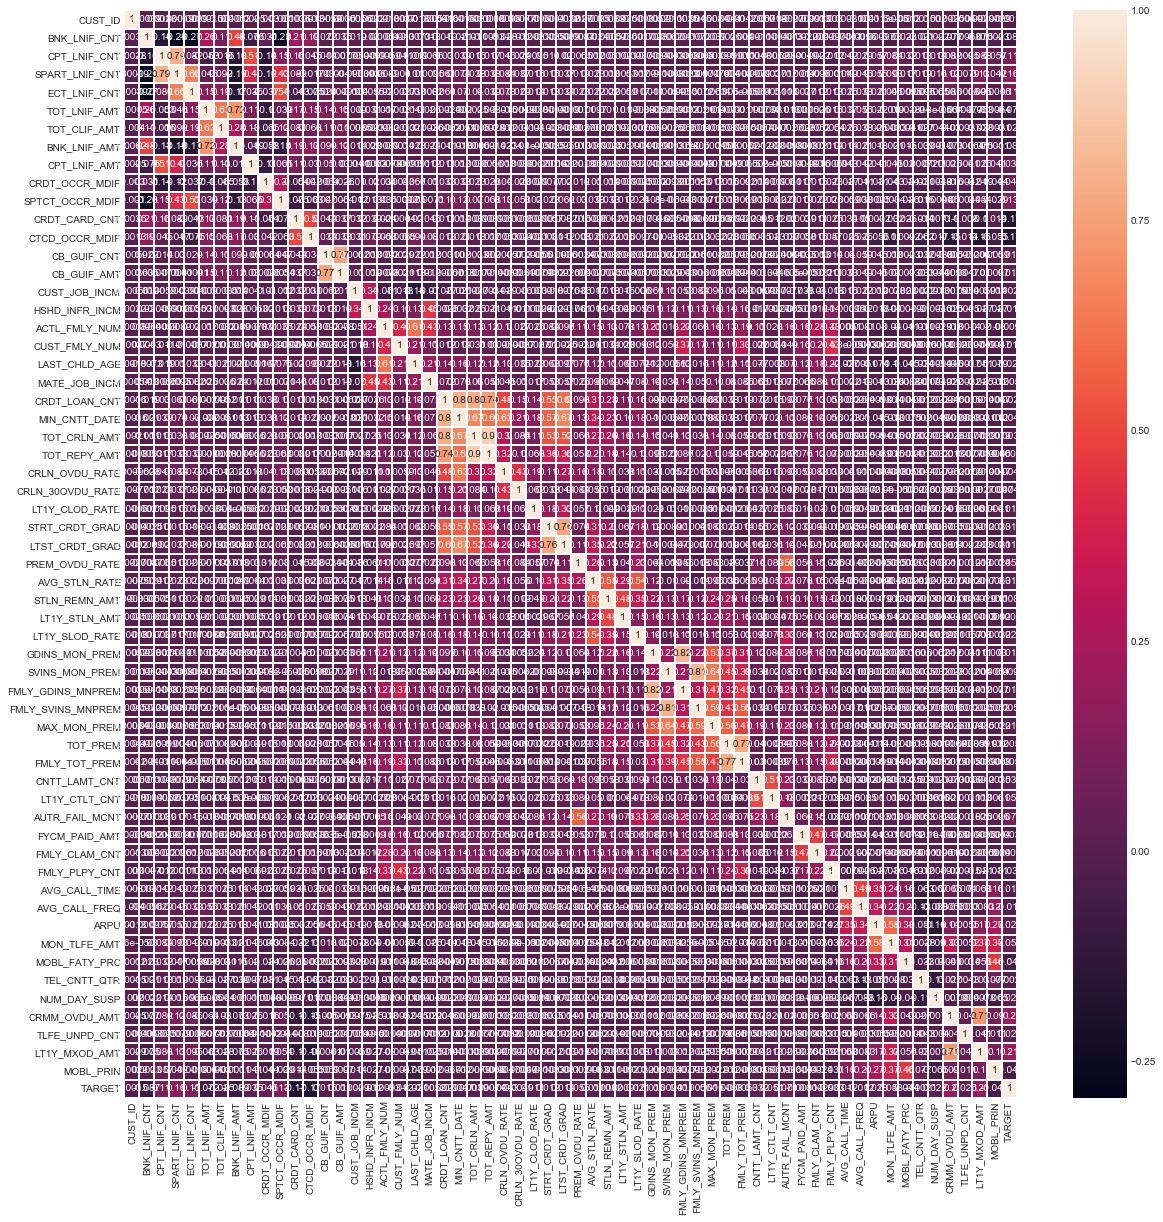

In [1155]:
plt.figure(figsize=(20 ,20))
draw = sns.heatmap(compare_feature, annot = True ,linewidths=1)
plt.show(draw)

# 3. 스케일링

- scale(X): 표준정상분포 Standard Normal Gaussian 기본 스케일
- robust_scale(X): median, interquartile range 사용. outlier 영향 최소화
- minmax_scale(X): 최대/최소값 사용
- maxabs_scale(X): 최대절대값 사용

In [1012]:
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

In [1013]:
label_list = list(X_train_label.columns)
label_list

['CUST_ID',
 'BNK_LNIF_CNT',
 'CPT_LNIF_CNT',
 'SPART_LNIF_CNT',
 'ECT_LNIF_CNT',
 'TOT_LNIF_AMT',
 'TOT_CLIF_AMT',
 'BNK_LNIF_AMT',
 'CPT_LNIF_AMT',
 'CRDT_OCCR_MDIF',
 'SPTCT_OCCR_MDIF',
 'CRDT_CARD_CNT',
 'CTCD_OCCR_MDIF',
 'CB_GUIF_CNT',
 'CB_GUIF_AMT',
 'CUST_JOB_INCM',
 'HSHD_INFR_INCM',
 'ACTL_FMLY_NUM',
 'CUST_FMLY_NUM',
 'LAST_CHLD_AGE',
 'MATE_JOB_INCM',
 'CRDT_LOAN_CNT',
 'MIN_CNTT_DATE',
 'TOT_CRLN_AMT',
 'TOT_REPY_AMT',
 'CRLN_OVDU_RATE',
 'CRLN_30OVDU_RATE',
 'LT1Y_CLOD_RATE',
 'STRT_CRDT_GRAD',
 'LTST_CRDT_GRAD',
 'PREM_OVDU_RATE',
 'AVG_STLN_RATE',
 'STLN_REMN_AMT',
 'LT1Y_STLN_AMT',
 'LT1Y_SLOD_RATE',
 'GDINS_MON_PREM',
 'SVINS_MON_PREM',
 'FMLY_GDINS_MNPREM',
 'FMLY_SVINS_MNPREM',
 'MAX_MON_PREM',
 'TOT_PREM',
 'FMLY_TOT_PREM',
 'CNTT_LAMT_CNT',
 'LT1Y_CTLT_CNT',
 'AUTR_FAIL_MCNT',
 'FYCM_PAID_AMT',
 'FMLY_CLAM_CNT',
 'FMLY_PLPY_CNT',
 'AGE',
 'AVG_CALL_TIME',
 'AVG_CALL_FREQ',
 'ARPU',
 'MON_TLFE_AMT',
 'MOBL_FATY_PRC',
 'TEL_CNTT_QTR',
 'NUM_DAY_SUSP',
 'CRMM_OVDU_A

In [1015]:
min_max_scaler = minmax_scale(X_train_label , feature_range=(0,1) )
scaler = scale(X_train_label)

In [1016]:
min_max_scaler = pd.DataFrame(min_max_scaler , columns=label_list)
min_max_scaler.head()

CUST_ID  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  ECT_LNIF_CNT  \
0  0.000000           0.2           0.0        0.000000      0.000000   
1  0.000010           0.2           0.0        0.000000      0.000000   
2  0.000020           0.0           0.2        0.428571      0.333333   
3  0.000029           0.0           0.4        0.571429      0.333333   
4  0.000039           0.8           0.0        0.000000      0.000000   

   TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  CRDT_OCCR_MDIF  \
0      0.009054      0.009055      0.009535       0.00000        0.008264   
1      0.024145      0.000000      0.025425       0.00000        0.000000   
2      0.015091      0.009055      0.000000       0.00997        0.008264   
3      0.006036      0.003019      0.000000       0.00997        0.008264   
4      0.021127      0.015092      0.022247       0.00000        0.008264   

            ...            LT1Y_MXOD_AMT  MOBL_PRIN  LT1Y_PEOD_RATE_LABEL  \
0           ...                  0.00000   0.527273                  0.25   
1           ...                  0.00000   0.081818                  0.00   
2           ...                  0.00000   0.109091                  0.00   
3           ...                  0.39375   0.290909                  0.00   
4           ...                  0.05625   0.372727                  0.00   

   SEX_LABEL  TEL_MBSP_GRAD_LABEL  CBPT_MBSP_YN_LABEL  PAYM_METD_LABEL  \
0        0.5                  0.0                 0.0             0.75   
1        0.5                  0.0                 0.0             0.75   
2        1.0                  0.0                 1.0             0.75   
3        0.5                  0.0                 0.0             0.25   
4        0.5                  1.0                 1.0             0.25   

   LINE_STUS_LABEL  OCCP_NAME_G_LABEL  MATE_OCCP_NAME_G_LABEL  
0              1.0           0.294118                0.941176  
1              1.0           0.823529                0.941176  
2              1.0           0.941176                0.117647  
3              0.0           1.000000                0.000000  
4              1.0           0.294118                0.941176  

[5 rows x 68 columns]

In [1017]:
robust_scaler_la = robust_scale(X_train_label)
robust_scaler_la = pd.DataFrame(robust_scaler_la , columns=label_list)
robust_scaler_la.head()

CUST_ID  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  ECT_LNIF_CNT  \
0 -0.999687           0.0           0.0            -1.0           0.0   
1 -0.999668           0.0           0.0            -1.0           0.0   
2 -0.999648          -1.0           1.0             2.0           2.0   
3 -0.999628          -1.0           2.0             3.0           2.0   
4 -0.999609           3.0           0.0            -1.0           0.0   

   TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  CRDT_OCCR_MDIF  \
0     -0.322581      0.000000      0.000000           0.0            0.00   
1     -0.161290     -0.300023      0.238091           0.0           -0.04   
2     -0.258065      0.000000     -0.142871           1.0            0.00   
3     -0.354839     -0.199993     -0.142871           1.0            0.00   
4     -0.193548      0.199993      0.190473           0.0            0.00   

            ...            LT1Y_MXOD_AMT  MOBL_PRIN  LT1Y_PEOD_RATE_LABEL  \
0           ...                      0.0    1.50000                   2.0   
1           ...                      0.0   -0.03125                   0.0   
2           ...                      0.0    0.06250                   0.0   
3           ...                 630000.0    0.68750                   0.0   
4           ...                  90000.0    0.96875                   0.0   

   SEX_LABEL  TEL_MBSP_GRAD_LABEL  CBPT_MBSP_YN_LABEL  PAYM_METD_LABEL  \
0       -1.0            -0.666667                 0.0              0.0   
1       -1.0            -0.666667                 0.0              0.0   
2        0.0            -0.666667                 1.0              0.0   
3       -1.0            -0.666667                 0.0             -2.0   
4       -1.0             0.666667                 1.0             -2.0   

   LINE_STUS_LABEL  OCCP_NAME_G_LABEL  MATE_OCCP_NAME_G_LABEL  
0              0.0          -0.545455                1.272727  
1              0.0           0.272727                1.272727  
2              0.0           0.454545                0.000000  
3             -1.0           0.545455               -0.181818  
4              0.0          -0.545455                1.272727  

[5 rows x 68 columns]

In [1018]:
onehot_list = list(X_train_onehot.columns)
onehot_list

['CUST_ID',
 'BNK_LNIF_CNT',
 'CPT_LNIF_CNT',
 'SPART_LNIF_CNT',
 'ECT_LNIF_CNT',
 'TOT_LNIF_AMT',
 'TOT_CLIF_AMT',
 'BNK_LNIF_AMT',
 'CPT_LNIF_AMT',
 'CRDT_OCCR_MDIF',
 'SPTCT_OCCR_MDIF',
 'CRDT_CARD_CNT',
 'CTCD_OCCR_MDIF',
 'CB_GUIF_CNT',
 'CB_GUIF_AMT',
 'CUST_JOB_INCM',
 'HSHD_INFR_INCM',
 'ACTL_FMLY_NUM',
 'CUST_FMLY_NUM',
 'LAST_CHLD_AGE',
 'MATE_JOB_INCM',
 'CRDT_LOAN_CNT',
 'MIN_CNTT_DATE',
 'TOT_CRLN_AMT',
 'TOT_REPY_AMT',
 'CRLN_OVDU_RATE',
 'CRLN_30OVDU_RATE',
 'LT1Y_CLOD_RATE',
 'STRT_CRDT_GRAD',
 'LTST_CRDT_GRAD',
 'PREM_OVDU_RATE',
 'AVG_STLN_RATE',
 'STLN_REMN_AMT',
 'LT1Y_STLN_AMT',
 'LT1Y_SLOD_RATE',
 'GDINS_MON_PREM',
 'SVINS_MON_PREM',
 'FMLY_GDINS_MNPREM',
 'FMLY_SVINS_MNPREM',
 'MAX_MON_PREM',
 'TOT_PREM',
 'FMLY_TOT_PREM',
 'CNTT_LAMT_CNT',
 'LT1Y_CTLT_CNT',
 'AUTR_FAIL_MCNT',
 'FYCM_PAID_AMT',
 'FMLY_CLAM_CNT',
 'FMLY_PLPY_CNT',
 'AGE',
 'AVG_CALL_TIME',
 'AVG_CALL_FREQ',
 'ARPU',
 'MON_TLFE_AMT',
 'MOBL_FATY_PRC',
 'TEL_CNTT_QTR',
 'NUM_DAY_SUSP',
 'CRMM_OVDU_A

In [1020]:
robust_scaler_oh = robust_scale(X_train_onehot)
robust_scaler_oh = pd.DataFrame(robust_scaler_oh , columns=onehot_list)
robust_scaler_oh.head()

CUST_ID  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  ECT_LNIF_CNT  \
0 -0.999687           0.0           0.0            -1.0           0.0   
1 -0.999668           0.0           0.0            -1.0           0.0   
2 -0.999648          -1.0           1.0             2.0           2.0   
3 -0.999628          -1.0           2.0             3.0           2.0   
4 -0.999609           3.0           0.0            -1.0           0.0   

   TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  CRDT_OCCR_MDIF  \
0     -0.322581      0.000000      0.000000           0.0            0.00   
1     -0.161290     -0.300023      0.238091           0.0           -0.04   
2     -0.258065      0.000000     -0.142871           1.0            0.00   
3     -0.354839     -0.199993     -0.142871           1.0            0.00   
4     -0.193548      0.199993      0.190473           0.0            0.00   

      ...       TEL_MBSP_GRAD_W  CBPT_MBSP_YN_N  CBPT_MBSP_YN_Y  PAYM_METD_0  \
0     ...                   0.0             0.0             0.0          0.0   
1     ...                   0.0             0.0             0.0          0.0   
2     ...                   0.0            -1.0             1.0          0.0   
3     ...                   0.0             0.0             0.0          0.0   
4     ...                   1.0            -1.0             1.0          0.0   

   PAYM_METD_G  PAYM_METD_K  PAYM_METD_O  PAYM_METD_R  LINE_STUS_S  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          1.0          0.0         -1.0          0.0          1.0   
4          1.0          0.0         -1.0          0.0          0.0   

   LINE_STUS_U  
0          0.0  
1          0.0  
2          0.0  
3         -1.0  
4          0.0  

[5 rows x 122 columns]

# 4. train, test set 분리

In [1021]:
from sklearn.model_selection import train_test_split

(1)스케일링한 데이터(label, onehot)

In [1022]:
s_train_label, s_test_label, s_train_label_y, s_test_label_y = \
train_test_split(robust_scaler_la[robust_scaler_la.columns.difference(['CUST_ID'])], Y_target,random_state=5)

In [1023]:
s_train_label.shape

(75174, 67)

In [1024]:
s_train_label.tail()

ACTL_FMLY_NUM       AGE      ARPU  AUTR_FAIL_MCNT  AVG_CALL_FREQ  \
59465            0.5  0.333333  0.000000             3.0       0.422886   
5520            -0.5 -1.000000  0.000000             0.5      -0.671642   
20463            0.5  0.000000 -1.333367             0.0      -0.338308   
18638           -0.5  0.000000  0.000000             0.0      -0.343284   
35683           -0.5  0.000000 -0.333333             0.5       0.169154   

       AVG_CALL_TIME  AVG_STLN_RATE  BNK_LNIF_AMT  BNK_LNIF_CNT  \
59465      -0.013699            0.0     -0.142871          -1.0   
5520       -0.301370            0.0     -0.142871          -1.0   
20463      -0.585616           25.0      0.857129           0.0   
18638       0.010274            0.0     -0.142855           0.0   
35683       0.493151            0.0      2.047587           0.0   

       CBPT_MBSP_YN_LABEL      ...       STRT_CRDT_GRAD  SVINS_MON_PREM  \
59465                 0.0      ...                  0.0             0.0   
5520                  0.0      ...                  0.0             0.0   
20463                 0.0      ...                  0.0             0.0   
18638                 0.0      ...                  0.0        990000.0   
35683                 1.0      ...                  0.0        790000.0   

       TEL_CNTT_QTR  TEL_MBSP_GRAD_LABEL  TLFE_UNPD_CNT  TOT_CLIF_AMT  \
59465      0.366667             0.000000            0.0      2.999900   
5520       0.300000             0.000000            0.0      0.000000   
20463      0.966667            -0.666667            0.0     -0.300023   
18638     -0.666667             0.333333            0.0     -0.299990   
35683      0.700000            -0.666667            0.0     -0.300023   

       TOT_CRLN_AMT  TOT_LNIF_AMT  TOT_PREM  TOT_REPY_AMT  
59465     5000000.0      0.645161  3.833333     5000000.0  
5520            0.0     -0.161290 -0.444444           0.0  
20463           0.0      0.258065  0.111111           0.0  
18638           0.0      0.129032 -0.444444           0.0  
35683           0.0      1.516129  7.111111           0.0  

[5 rows x 67 columns]

In [1025]:
s_train_onehot, s_test_onehot, s_train_onehot_y, s_test_onehot_y= \
train_test_split(robust_scaler_oh[robust_scaler_oh.columns.difference(['CUST_ID'])],Y_target,random_state=5)

In [1026]:
s_train_onehot.shape

(75174, 121)

In [1027]:
s_train_onehot.tail()

ACTL_FMLY_NUM       AGE      ARPU  AUTR_FAIL_MCNT  AVG_CALL_FREQ  \
59465            0.5  0.333333  0.000000             3.0       0.422886   
5520            -0.5 -1.000000  0.000000             0.5      -0.671642   
20463            0.5  0.000000 -1.333367             0.0      -0.338308   
18638           -0.5  0.000000  0.000000             0.0      -0.343284   
35683           -0.5  0.000000 -0.333333             0.5       0.169154   

       AVG_CALL_TIME  AVG_STLN_RATE  BNK_LNIF_AMT  BNK_LNIF_CNT  \
59465      -0.013699            0.0     -0.142871          -1.0   
5520       -0.301370            0.0     -0.142871          -1.0   
20463      -0.585616           25.0      0.857129           0.0   
18638       0.010274            0.0     -0.142855           0.0   
35683       0.493151            0.0      2.047587           0.0   

       CBPT_MBSP_YN_N      ...       TEL_MBSP_GRAD_E  TEL_MBSP_GRAD_Q  \
59465             0.0      ...                   0.0              1.0   
5520              0.0      ...                   0.0              1.0   
20463             0.0      ...                   0.0              0.0   
18638             0.0      ...                   0.0              0.0   
35683            -1.0      ...                   0.0              0.0   

       TEL_MBSP_GRAD_R  TEL_MBSP_GRAD_W  TLFE_UNPD_CNT  TOT_CLIF_AMT  \
59465              0.0              0.0            0.0      2.999900   
5520               0.0              0.0            0.0      0.000000   
20463              0.0              0.0            0.0     -0.300023   
18638              1.0              0.0            0.0     -0.299990   
35683              0.0              0.0            0.0     -0.300023   

       TOT_CRLN_AMT  TOT_LNIF_AMT  TOT_PREM  TOT_REPY_AMT  
59465     5000000.0      0.645161  3.833333     5000000.0  
5520            0.0     -0.161290 -0.444444           0.0  
20463           0.0      0.258065  0.111111           0.0  
18638           0.0      0.129032 -0.444444           0.0  
35683           0.0      1.516129  7.111111           0.0  

[5 rows x 121 columns]

(2)스케일링하지 않은 데이터(label, onehot)

In [1028]:
train_label, test_label, train_label_y, test_label_y  = \
train_test_split(X_train_label[X_train_label.columns.difference(['CUST_ID'])],Y_target,random_state=3)

In [1029]:
train_label.shape

(75174, 67)

In [1030]:
train_label.tail()

ACTL_FMLY_NUM  AGE   ARPU  AUTR_FAIL_MCNT  AVG_CALL_FREQ  \
48056              4   35  40000               0             72   
59011              2   50  50000               0            571   
77049              2   35  30000               2            166   
67224              5   40  60000               0            225   
71530              3   60  40000               0            325   

       AVG_CALL_TIME  AVG_STLN_RATE  BNK_LNIF_AMT  BNK_LNIF_CNT  \
48056             79             89             0             0   
59011            312              0             0             0   
77049            108              0         18001             1   
67224            642              0         51001             3   
71530            303              0         75001             1   

       CBPT_MBSP_YN_LABEL      ...       STRT_CRDT_GRAD  SVINS_MON_PREM  \
48056                   0      ...                    0               0   
59011                   0      ...                    0               0   
77049                   1      ...                    0               0   
67224                   1      ...                    0               0   
71530                   0      ...                    0               0   

       TEL_CNTT_QTR  TEL_MBSP_GRAD_LABEL  TLFE_UNPD_CNT  TOT_CLIF_AMT  \
48056         20132                    0              0             0   
59011         20114                    0              0         15001   
77049         20152                    2              0         18001   
67224         20134                    4              0         51001   
71530         20121                    0              0             0   

       TOT_CRLN_AMT  TOT_LNIF_AMT  TOT_PREM  TOT_REPY_AMT  
48056             0         15001  23000000             0  
59011             0         15001   5000000             0  
77049             0         18001   8000000             0  
67224             0         51001  21000000             0  
71530             0         75001   1000000             0  

[5 rows x 67 columns]

In [1031]:
train_onehot, test_onehot,  train_onehot_y, test_onehot_y = \
train_test_split(X_train_onehot[X_train_onehot.columns.difference(['CUST_ID'])], Y_target,random_state=3)

In [1032]:
train_onehot.shape

(75174, 121)

In [1033]:
train_onehot.tail()

ACTL_FMLY_NUM  AGE   ARPU  AUTR_FAIL_MCNT  AVG_CALL_FREQ  \
48056              4   35  40000               0             72   
59011              2   50  50000               0            571   
77049              2   35  30000               2            166   
67224              5   40  60000               0            225   
71530              3   60  40000               0            325   

       AVG_CALL_TIME  AVG_STLN_RATE  BNK_LNIF_AMT  BNK_LNIF_CNT  \
48056             79             89             0             0   
59011            312              0             0             0   
77049            108              0         18001             1   
67224            642              0         51001             3   
71530            303              0         75001             1   

       CBPT_MBSP_YN_N      ...       TEL_MBSP_GRAD_E  TEL_MBSP_GRAD_Q  \
48056               1      ...                     0                0   
59011               1      ...                     0                0   
77049               0      ...                     0                1   
67224               0      ...                     0                0   
71530               1      ...                     0                0   

       TEL_MBSP_GRAD_R  TEL_MBSP_GRAD_W  TLFE_UNPD_CNT  TOT_CLIF_AMT  \
48056                0                0              0             0   
59011                0                0              0         15001   
77049                0                0              0         18001   
67224                0                1              0         51001   
71530                0                0              0             0   

       TOT_CRLN_AMT  TOT_LNIF_AMT  TOT_PREM  TOT_REPY_AMT  
48056             0         15001  23000000             0  
59011             0         15001   5000000             0  
77049             0         18001   8000000             0  
67224             0         51001  21000000             0  
71530             0         75001   1000000             0  

[5 rows x 121 columns]

(3) 카테고리 변수를 제거한 데이터 

In [1169]:
train_cate = train_X.copy()

In [1170]:
cate_list

['LT1Y_PEOD_RATE',
 'SEX',
 'TEL_MBSP_GRAD',
 'CBPT_MBSP_YN',
 'PAYM_METD',
 'LINE_STUS',
 'OCCP_NAME_G',
 'MATE_OCCP_NAME_G']

In [1171]:
for i in cate_list:
    del train_cate[i]

In [1173]:
train_cate.tail()

CUST_ID  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  ECT_LNIF_CNT  \
100228   102248             1             0               2             2   
100229   102249             2             0               0             0   
100230   102250             1             0               0             0   
100231   102251             0             0               1             1   
100232   102252             1             0               0             0   

        TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  \
100228         75001         15001         57001             0   
100229         54001          9001         54001             0   
100230         27001         27001         27001             0   
100231         57001             0             0             0   
100232         18001         18001         18001             0   

        CRDT_OCCR_MDIF    ...      AVG_CALL_FREQ   ARPU  MON_TLFE_AMT  \
100228              37    ...                 38  20000         20000   
100229              85    ...                201  50000         80000   
100230               1    ...                171  50000         20000   
100231               1    ...                119  50000        180000   
100232              49    ...                 12  20000         40000   

        MOBL_FATY_PRC  TEL_CNTT_QTR  NUM_DAY_SUSP  CRMM_OVDU_AMT  \
100228              0         20111             0          20000   
100229         900000         20134             0              0   
100230              0         20141             0              0   
100231         900000         20103             0              0   
100232         400000         20151             0              0   

        TLFE_UNPD_CNT  LT1Y_MXOD_AMT  MOBL_PRIN  
100228              0              0          0  
100229              0              0     180000  
100230              0              0          0  
100231              0              0     540000  
100232              0          60000     180000  

[5 rows x 60 columns]

In [1175]:
train_cate, test_cate,  train_cate_y, test_cate_y = \
train_test_split(train_cate[train_cate.columns.difference(['CUST_ID'])], Y_target,random_state=3)

# 5. Model Selection

### (1) random forest

In [1034]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import f1_score

In [1050]:
def feature_importances(train_data,  test_data, train_target,test_target):
    rf = RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=0,n_jobs=-1)
    rf.fit(train_data, train_target)
    rf.feature_importances_
    return selectModel(rf, train_data,  test_data, train_target,test_target)

In [1051]:
def selectModel(rf, train_data,  test_data, train_target,test_target):
    model = SelectFromModel(rf, prefit=True)
    feature_idx = model.get_support()
    feature_name = train_data.columns[feature_idx]
    train_data = model.transform(train_data)
    test_data = model.transform(test_data)
    global train_data_df
    train_data_df = pd.DataFrame(train_data, columns=feature_name)
    global test_data_df 
    test_data_df = pd.DataFrame(test_data, columns=feature_name)
    return gridsearch(train_data_df ,train_target, test_data_df , test_target)

In [1052]:
def gridsearch(train_data ,train_target ,test_data, test_target):
    param = [{'n_estimators':[100, 300, 500],
         'criterion': ['gini', 'entropy']}]
    model = GridSearchCV(RandomForestClassifier(n_jobs=-1), param, cv=3)
    model.fit(train_data, train_target)
    print (model.best_params_)
    global pred_y
    pred_y = model.predict_proba(test_data)
    pred_y= pd.DataFrame(pred_y, columns=['n','y'])
    pred_y= pd.DataFrame(pred_y, columns=['n','y'])
    del pred_y['n']
    #print (pred_y)
    return f1score(pred_y,test_target)

In [1060]:
def f1score(pred_y,test_target):
    i = 0.0
    f1_max = 0
    while(i <= 1.0):
        pred = pred_y['y'].apply(lambda x: 1 if x > i else 0)
        f1 = f1_score(test_target, pred)
        if f1 > f1_max:
            f1_max = f1
            #print (i)
        #print ('i = {}, f1_max = {}'.format(i, f1_max))
        i += 0.001
    return f1_max

스케일링한 label 변수 67개 --> 29개

In [1039]:
s_train_label.tail()

ACTL_FMLY_NUM       AGE      ARPU  AUTR_FAIL_MCNT  AVG_CALL_FREQ  \
59465            0.5  0.333333  0.000000             3.0       0.422886   
5520            -0.5 -1.000000  0.000000             0.5      -0.671642   
20463            0.5  0.000000 -1.333367             0.0      -0.338308   
18638           -0.5  0.000000  0.000000             0.0      -0.343284   
35683           -0.5  0.000000 -0.333333             0.5       0.169154   

       AVG_CALL_TIME  AVG_STLN_RATE  BNK_LNIF_AMT  BNK_LNIF_CNT  \
59465      -0.013699            0.0     -0.142871          -1.0   
5520       -0.301370            0.0     -0.142871          -1.0   
20463      -0.585616           25.0      0.857129           0.0   
18638       0.010274            0.0     -0.142855           0.0   
35683       0.493151            0.0      2.047587           0.0   

       CBPT_MBSP_YN_LABEL      ...       STRT_CRDT_GRAD  SVINS_MON_PREM  \
59465                 0.0      ...                  0.0             0.0   
5520                  0.0      ...                  0.0             0.0   
20463                 0.0      ...                  0.0             0.0   
18638                 0.0      ...                  0.0        990000.0   
35683                 1.0      ...                  0.0        790000.0   

       TEL_CNTT_QTR  TEL_MBSP_GRAD_LABEL  TLFE_UNPD_CNT  TOT_CLIF_AMT  \
59465      0.366667             0.000000            0.0      2.999900   
5520       0.300000             0.000000            0.0      0.000000   
20463      0.966667            -0.666667            0.0     -0.300023   
18638     -0.666667             0.333333            0.0     -0.299990   
35683      0.700000            -0.666667            0.0     -0.300023   

       TOT_CRLN_AMT  TOT_LNIF_AMT  TOT_PREM  TOT_REPY_AMT  
59465     5000000.0      0.645161  3.833333     5000000.0  
5520            0.0     -0.161290 -0.444444           0.0  
20463           0.0      0.258065  0.111111           0.0  
18638           0.0      0.129032 -0.444444           0.0  
35683           0.0      1.516129  7.111111           0.0  

[5 rows x 67 columns]

In [1040]:
s_train_label_y.tail()

59465    0
5520     0
20463    0
18638    0
35683    0
Name: TARGET, dtype: int64

In [1061]:
feature_importances(s_train_label, s_test_label, s_train_label_y, s_test_label_y)

{'criterion': 'gini', 'n_estimators': 100}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



0.42221280203476053

In [1054]:
feature_importances(s_train_onehot, s_test_onehot, s_train_onehot_y, s_test_onehot_y)

{'criterion': 'gini', 'n_estimators': 100}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



0.43940643033800492

In [1055]:
feature_importances(train_label, test_label, train_label_y, test_label_y)

{'criterion': 'entropy', 'n_estimators': 300}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



0.46690168429298862

In [1056]:
feature_importances(train_onehot, test_onehot,  train_onehot_y, test_onehot_y)

{'criterion': 'gini', 'n_estimators': 300}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



0.46006944444444436

In [1176]:
feature_importances(train_cate, test_cate,  train_cate_y, test_cate_y)

{'criterion': 'entropy', 'n_estimators': 300}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



0.46806790622473726

### (2) xgboost

In [387]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
import graphviz

스케일링한 데이터 프레임 사용

In [631]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_eval, y_eval) 
# parameter 참조 link : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
xgb_params = {
    "objective"         : "binary:logistic" # loss function. binary:logistic (logistic regression for binary classification => predicted class) # multi:softmax (multicalss classification using the softmax objective -> predicted class , ) # multi:softprob: softmax와 같으나 class 대신 probability를 return
    #,"num_class"        : 2                # multi:softmax 쓸 경우, num_class (number of unique classes) 세팅해줘야함
    ,"eval_metric"      : "auc"              # validation에 사용될 metric (종류: rmse, mae, logloss, error, merror, mlogloss, auc)
    ,"eta"              : 0.1                # learning rate in GBM과 유사한 개념 (통상 0.01 ~ 0.2 사이 값)
    ,"max_depth"        : 6                  # maximum depth of a tree (overfitting 방지 위해 사용. depth 클수록 구체적 관계 학습. 통상 3 - 10) 
    ,"min_child_weight" : 10                 # minimum sum of weights of all observations (default=1, overfitting 방지를 위해 사용, 너무 높으면 underfitting 우려)
    ,"gamma"            : 0.70                # 분할에 필요한 최소 손실 함수, 이 이상으로 감소할 때만 분할됨 (default = 0)
    ,"subsample"        : 0.76                # 각 트리에 대해 임의의 샘플이되는 관측 값의 비율. 낮은 값이 보수적&overfitting을 막음. 너무 낮으면 underfitting 우려 (통상 0.5 - 1)
    ,"colsample_bytree" : 0.95                # 각 트리에 대해 임의의 샘플이 되는 columns의 비율. (default 1, 통상 0.5 - 1)
    ,"alpha"            : 2e-05               # L1 regularization term on weights (Lasso Regression) (default=0)
    ,"lambda"           :1                   # L2 regularization term on weights.(Ridge Regression) (default=1)
}

watchlist  = [(xgb_eval,'eval'), (xgb_train,'train')]

In [632]:
print('training XGBoost model ...')
xgb_model = xgb.train(params = xgb_params,
                dtrain = xgb_train,
                num_boost_round = 300,
                evals = (watchlist),
                verbose_eval=10) 

training XGBoost model ...
[0]	eval-auc:0.875354	train-auc:0.879345
[10]	eval-auc:0.907971	train-auc:0.915139
[20]	eval-auc:0.913307	train-auc:0.92341
[30]	eval-auc:0.918407	train-auc:0.930295
[40]	eval-auc:0.922637	train-auc:0.936483
[50]	eval-auc:0.925005	train-auc:0.941722
[60]	eval-auc:0.926809	train-auc:0.945765
[70]	eval-auc:0.927945	train-auc:0.949342
[80]	eval-auc:0.928732	train-auc:0.95173
[90]	eval-auc:0.929808	train-auc:0.954153
[100]	eval-auc:0.930244	train-auc:0.956017
[110]	eval-auc:0.93026	train-auc:0.957868
[120]	eval-auc:0.929993	train-auc:0.960131
[130]	eval-auc:0.93014	train-auc:0.961718
[140]	eval-auc:0.930566	train-auc:0.963259
[150]	eval-auc:0.930592	train-auc:0.965437
[160]	eval-auc:0.930399	train-auc:0.967276
[170]	eval-auc:0.930163	train-auc:0.969042
[180]	eval-auc:0.930034	train-auc:0.970292
[190]	eval-auc:0.929531	train-auc:0.971595
[200]	eval-auc:0.929588	train-auc:0.972785
[210]	eval-auc:0.929317	train-auc:0.973925
[220]	eval-auc:0.929336	train-auc:0.974705

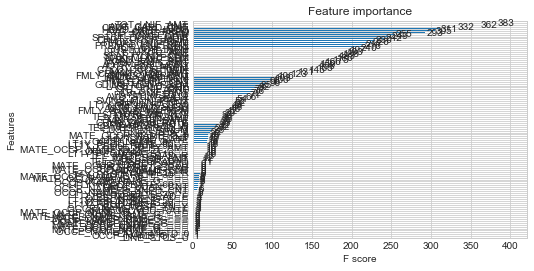

In [633]:
xgb.plot_importance(xgb_model,height=0.2)

In [635]:
a = xgb_model.get_score(importance_type='gain')
a = a.keys()

In [641]:
a = list(a)
len(a)

110

In [611]:
X_eval.tail()

0    1    2    3    4         5         6         7         8    \
73276  0.462256  0.0  2.0  2.0  1.0 -0.096774  0.499983 -0.047618  1.999667   
38129 -0.239195 -1.0  0.0  0.0  1.0 -0.322581  0.000000 -0.142871  0.000000   
57545  0.147945  0.0  0.0  0.0  1.0 -0.193548  0.399987  0.095237  0.000000   
31238 -0.376403 -1.0  0.0  0.0  1.0  1.806452  6.599780 -0.142871  0.000000   
48537 -0.031388  0.0  1.0  1.0  1.0 -0.161290  0.299990 -0.095237  1.000000   

        9   ...   112  113  114  115  116  117  118  119  120  121  
73276  0.00 ...   1.0  0.0  0.0  0.0  0.0  1.0 -1.0  0.0  0.0  0.0  
38129  0.00 ...   0.0 -1.0  1.0  0.0  0.0  1.0 -1.0  0.0  0.0  0.0  
57545  0.00 ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
31238  0.00 ...   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
48537  1.44 ...   1.0 -1.0  1.0  0.0  0.0  1.0 -1.0  0.0  0.0  0.0  

[5 rows x 122 columns]

In [612]:
X_eval2 = xgb.DMatrix(X_eval)

In [613]:
pred = xgb_model.predict(X_eval2)

In [614]:
pred2 = np.array(pred)

In [615]:
pred2

array([  1.60238165e-02,   9.46887136e-02,   6.69977453e-05, ...,
         1.04158362e-02,   2.17057150e-02,   4.55794297e-02], dtype=float32)

In [616]:
pred2= pd.DataFrame(pred2 ,columns=['TARGET'])

In [617]:
pred2.head()

TARGET
0  0.016024
1  0.094689
2  0.000067
3  0.001006
4  0.032141

In [618]:
pred3 = pred2['TARGET'].apply(lambda x: 1 if x > 0.167 else 0)

In [619]:
f1_score(y_eval, pred3)

0.45151422453349643

In [624]:
i = 0
f1_max = 0
while(i <= 1.0):
    pred3 = pred2['TARGET'].apply(lambda x: 1 if x > i else 0)
    f1 = f1_score(y_eval, pred3)
    if f1 > f1_max:
        f1_max = f1
        #print (i)
    #print ('i = {}, f1_max = {}'.format(i, f1_max))
    i += 0.001
print (f1_max)
    

0.454479768786


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.



스케일링 한 데이터프레임은 : 0.227 , f1_score : 0.45151422
스케일링 하지 않은 데이터프레임은 : 0.167  f1_score :0.4

### (3) lightGB